<a href="https://colab.research.google.com/github/Jaewon45/ESAA_2022/blob/main/1205_CNN_DogCatClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [10]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

## Define Constants

In [60]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## Prepare Traning Data

In [15]:
filenames = os.listdir("/content/drive/MyDrive/Colab Notebooks/train_700")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [17]:
df['category'].value_counts()

0    701
1    701
Name: category, dtype: int64

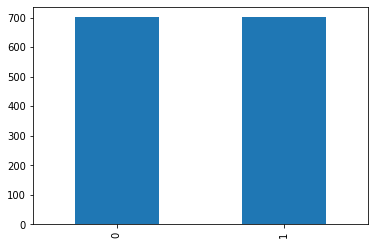

In [16]:
df['category'].value_counts().plot.bar()

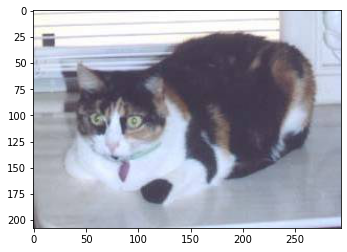

In [19]:
# sample image
sample = random.choice(filenames)
image = load_img("/content/drive/MyDrive/Colab Notebooks/train_700/"+sample)
plt.imshow(image)

## Build Model

In [20]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       2

## Callbacks

In [21]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

## Prepare Data

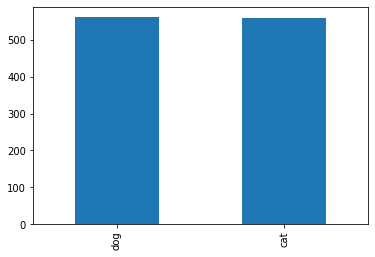

In [22]:
# encoding
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

# split
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

# 시각화
train_df['category'].value_counts().plot.bar()

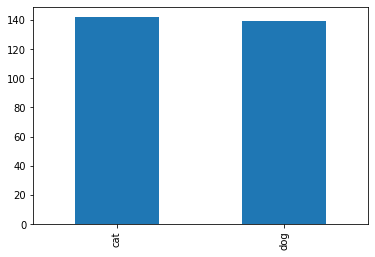

In [23]:
validate_df['category'].value_counts().plot.bar()

In [24]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

## Image Generator

In [36]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/MyDrive/Colab Notebooks/train_700/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1121 validated image filenames belonging to 2 classes.


In [32]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/Colab Notebooks/train_700/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 281 validated image filenames belonging to 2 classes.


In [34]:
# example test
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/drive/MyDrive/Colab Notebooks/train_700/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


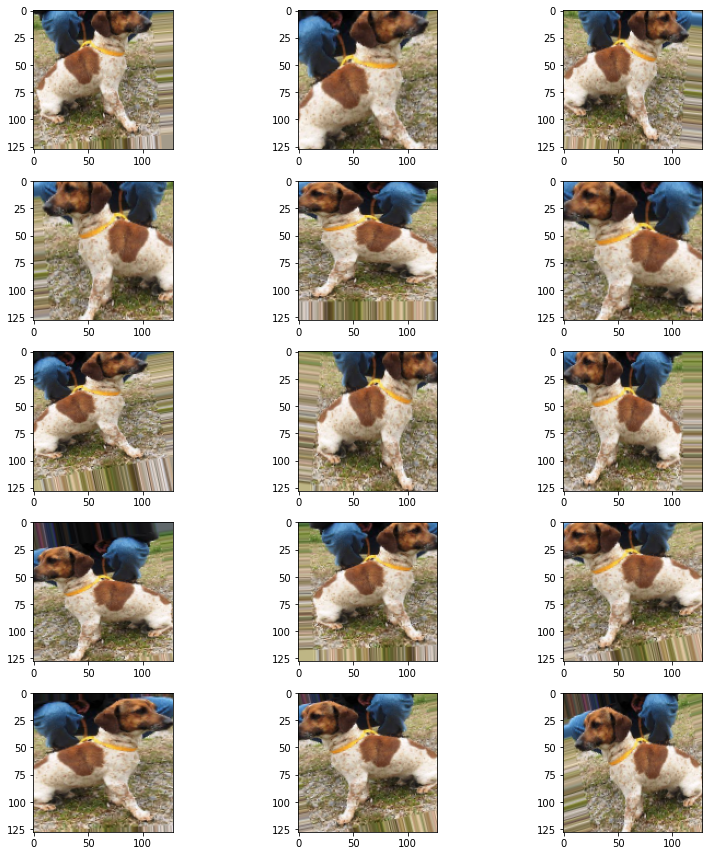

In [37]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Fit Model

In [62]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size, # 몫(정수)
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/50


<ipython-input-62-5859ffb42034>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


74/74 [==============================] - ETA: 0s - loss: 0.6457 - accuracy: 0.6420

74/74 [==============================] - 66s 889ms/step - loss: 0.6457 - accuracy: 0.6420 - val_loss: 0.6290 - val_accuracy: 0.6593 - lr: 0.0010
Epoch 2/50
74/74 [==============================] - ETA: 0s - loss: 0.5778 - accuracy: 0.7306

74/74 [==============================] - 64s 858ms/step - loss: 0.5778 - accuracy: 0.7306 - val_loss: 0.8004 - val_accuracy: 0.5593 - lr: 0.0010
Epoch 3/50
74/74 [==============================] - ETA: 0s - loss: 0.5928 - accuracy: 0.7061

74/74 [==============================] - 64s 859ms/step - loss: 0.5928 - accuracy: 0.7061 - val_loss: 1.1746 - val_accuracy: 0.5889 - lr: 0.0010
Epoch 4/50
74/74 [==============================] - ETA: 0s - loss: 0.6066 - accuracy: 0.7071

74/74 [==============================] - 66s 888ms/step - loss: 0.6066 - accuracy: 0.7071 - val_loss: 0.7895 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 5/50
74/74 [==============================] - ETA: 0s - loss: 0.5843 - accuracy: 0.7071

74/74 [==============================] - 64s 858ms/step - loss: 0.5843 - accuracy: 0.7071 - val_loss: 0.7398 - val_accuracy: 0.6370 - lr: 0.0010
Epoch 6/50
74/74 [==============================] - ETA: 0s - loss: 0.5704 - accuracy: 0.7233

74/74 [==============================] - 64s 859ms/step - loss: 0.5704 - accuracy: 0.7233 - val_loss: 0.7575 - val_accuracy: 0.5963 - lr: 0.0010
Epoch 7/50
74/74 [==============================] - ETA: 0s - loss: 0.5707 - accuracy: 0.7260

74/74 [==============================] - 64s 860ms/step - loss: 0.5707 - accuracy: 0.7260 - val_loss: 0.7397 - val_accuracy: 0.6593 - lr: 0.0010
Epoch 8/50
74/74 [==============================] - ETA: 0s - loss: 0.5424 - accuracy: 0.7432

74/74 [==============================] - 64s 861ms/step - loss: 0.5424 - accuracy: 0.7432 - val_loss: 0.5771 - val_accuracy: 0.7481 - lr: 0.0010
Epoch 9/50
74/74 [==============================] - ETA: 0s - loss: 0.5101 - accuracy: 0.7514

74/74 [==============================] - 64s 858ms/step - loss: 0.5101 - accuracy: 0.7514 - val_loss: 0.6959 - val_accuracy: 0.6630 - lr: 0.0010
Epoch 10/50
74/74 [==============================] - ETA: 0s - loss: 0.5474 - accuracy: 0.7396

74/74 [==============================] - 64s 857ms/step - loss: 0.5474 - accuracy: 0.7396 - val_loss: 0.6319 - val_accuracy: 0.6815 - lr: 0.0010
Epoch 11/50
74/74 [==============================] - ETA: 0s - loss: 0.5008 - accuracy: 0.7604

74/74 [==============================] - 63s 857ms/step - loss: 0.5008 - accuracy: 0.7604 - val_loss: 1.4356 - val_accuracy: 0.5741 - lr: 0.0010
Epoch 12/50
74/74 [==============================] - ETA: 0s - loss: 0.5290 - accuracy: 0.7450

74/74 [==============================] - 64s 861ms/step - loss: 0.5290 - accuracy: 0.7450 - val_loss: 0.5739 - val_accuracy: 0.7259 - lr: 0.0010
Epoch 13/50
74/74 [==============================] - ETA: 0s - loss: 0.4914 - accuracy: 0.7758

74/74 [==============================] - 64s 862ms/step - loss: 0.4914 - accuracy: 0.7758 - val_loss: 0.5945 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 14/50
74/74 [==============================] - ETA: 0s - loss: 0.4868 - accuracy: 0.7586

74/74 [==============================] - 67s 906ms/step - loss: 0.4868 - accuracy: 0.7586 - val_loss: 0.6253 - val_accuracy: 0.6889 - lr: 0.0010
Epoch 15/50
74/74 [==============================] - ETA: 0s - loss: 0.4921 - accuracy: 0.7604

74/74 [==============================] - 64s 860ms/step - loss: 0.4921 - accuracy: 0.7604 - val_loss: 0.6614 - val_accuracy: 0.6778 - lr: 0.0010
Epoch 16/50
74/74 [==============================] - ETA: 0s - loss: 0.4715 - accuracy: 0.7740

74/74 [==============================] - 64s 865ms/step - loss: 0.4715 - accuracy: 0.7740 - val_loss: 0.5500 - val_accuracy: 0.7519 - lr: 0.0010
Epoch 17/50
74/74 [==============================] - ETA: 0s - loss: 0.4654 - accuracy: 0.7722

74/74 [==============================] - 66s 889ms/step - loss: 0.4654 - accuracy: 0.7722 - val_loss: 0.5862 - val_accuracy: 0.7370 - lr: 0.0010
Epoch 18/50
74/74 [==============================] - ETA: 0s - loss: 0.4826 - accuracy: 0.7722

74/74 [==============================] - 64s 861ms/step - loss: 0.4826 - accuracy: 0.7722 - val_loss: 0.5285 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 19/50
74/74 [==============================] - ETA: 0s - loss: 0.4594 - accuracy: 0.7830

74/74 [==============================] - 64s 861ms/step - loss: 0.4594 - accuracy: 0.7830 - val_loss: 0.5849 - val_accuracy: 0.7481 - lr: 0.0010
Epoch 20/50
74/74 [==============================] - ETA: 0s - loss: 0.4679 - accuracy: 0.7577

74/74 [==============================] - 66s 892ms/step - loss: 0.4679 - accuracy: 0.7577 - val_loss: 0.5730 - val_accuracy: 0.7556 - lr: 0.0010
Epoch 21/50
74/74 [==============================] - ETA: 0s - loss: 0.4543 - accuracy: 0.7856

74/74 [==============================] - 64s 867ms/step - loss: 0.4543 - accuracy: 0.7856 - val_loss: 0.5231 - val_accuracy: 0.7704 - lr: 0.0010
Epoch 22/50
74/74 [==============================] - ETA: 0s - loss: 0.4368 - accuracy: 0.7902

74/74 [==============================] - 64s 863ms/step - loss: 0.4368 - accuracy: 0.7902 - val_loss: 0.7395 - val_accuracy: 0.7037 - lr: 0.0010
Epoch 23/50
74/74 [==============================] - ETA: 0s - loss: 0.4534 - accuracy: 0.7848

74/74 [==============================] - 66s 892ms/step - loss: 0.4534 - accuracy: 0.7848 - val_loss: 0.6035 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 24/50
74/74 [==============================] - ETA: 0s - loss: 0.4246 - accuracy: 0.7966

74/74 [==============================] - 64s 862ms/step - loss: 0.4246 - accuracy: 0.7966 - val_loss: 0.7866 - val_accuracy: 0.6444 - lr: 0.0010
Epoch 25/50
74/74 [==============================] - ETA: 0s - loss: 0.4158 - accuracy: 0.8056

74/74 [==============================] - 64s 861ms/step - loss: 0.4158 - accuracy: 0.8056 - val_loss: 0.6921 - val_accuracy: 0.6852 - lr: 0.0010
Epoch 26/50
74/74 [==============================] - ETA: 0s - loss: 0.4108 - accuracy: 0.8174

74/74 [==============================] - 66s 889ms/step - loss: 0.4108 - accuracy: 0.8174 - val_loss: 0.6328 - val_accuracy: 0.7407 - lr: 0.0010
Epoch 27/50
74/74 [==============================] - ETA: 0s - loss: 0.3972 - accuracy: 0.8282

74/74 [==============================] - 64s 860ms/step - loss: 0.3972 - accuracy: 0.8282 - val_loss: 1.0343 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 28/50
74/74 [==============================] - ETA: 0s - loss: 0.4535 - accuracy: 0.7920

74/74 [==============================] - 64s 863ms/step - loss: 0.4535 - accuracy: 0.7920 - val_loss: 0.5179 - val_accuracy: 0.7889 - lr: 0.0010
Epoch 29/50
74/74 [==============================] - ETA: 0s - loss: 0.4419 - accuracy: 0.8183

74/74 [==============================] - 64s 864ms/step - loss: 0.4419 - accuracy: 0.8183 - val_loss: 0.4903 - val_accuracy: 0.7889 - lr: 0.0010
Epoch 30/50
74/74 [==============================] - ETA: 0s - loss: 0.4169 - accuracy: 0.8128

74/74 [==============================] - 65s 871ms/step - loss: 0.4169 - accuracy: 0.8128 - val_loss: 0.9186 - val_accuracy: 0.7259 - lr: 0.0010
Epoch 31/50
74/74 [==============================] - ETA: 0s - loss: 0.3868 - accuracy: 0.8192

74/74 [==============================] - 64s 860ms/step - loss: 0.3868 - accuracy: 0.8192 - val_loss: 0.5237 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 32/50
74/74 [==============================] - ETA: 0s - loss: 0.4127 - accuracy: 0.8219

74/74 [==============================] - 64s 859ms/step - loss: 0.4127 - accuracy: 0.8219 - val_loss: 0.6015 - val_accuracy: 0.7370 - lr: 0.0010
Epoch 33/50
74/74 [==============================] - ETA: 0s - loss: 0.3988 - accuracy: 0.8183

74/74 [==============================] - 65s 862ms/step - loss: 0.3988 - accuracy: 0.8183 - val_loss: 0.7378 - val_accuracy: 0.7185 - lr: 0.0010
Epoch 34/50
74/74 [==============================] - ETA: 0s - loss: 0.3815 - accuracy: 0.8228

74/74 [==============================] - 64s 860ms/step - loss: 0.3815 - accuracy: 0.8228 - val_loss: 0.5055 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 35/50
74/74 [==============================] - ETA: 0s - loss: 0.3896 - accuracy: 0.8282

74/74 [==============================] - 64s 857ms/step - loss: 0.3896 - accuracy: 0.8282 - val_loss: 0.5080 - val_accuracy: 0.7889 - lr: 0.0010
Epoch 36/50
74/74 [==============================] - ETA: 0s - loss: 0.3945 - accuracy: 0.8110

74/74 [==============================] - 66s 887ms/step - loss: 0.3945 - accuracy: 0.8110 - val_loss: 0.7574 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 37/50
74/74 [==============================] - ETA: 0s - loss: 0.4070 - accuracy: 0.8128

74/74 [==============================] - 64s 860ms/step - loss: 0.4070 - accuracy: 0.8128 - val_loss: 1.3220 - val_accuracy: 0.6704 - lr: 0.0010
Epoch 38/50
74/74 [==============================] - ETA: 0s - loss: 0.3865 - accuracy: 0.8273

74/74 [==============================] - 64s 862ms/step - loss: 0.3865 - accuracy: 0.8273 - val_loss: 0.6401 - val_accuracy: 0.7519 - lr: 0.0010
Epoch 39/50
74/74 [==============================] - ETA: 0s - loss: 0.3874 - accuracy: 0.8228

74/74 [==============================] - 64s 861ms/step - loss: 0.3874 - accuracy: 0.8228 - val_loss: 0.4952 - val_accuracy: 0.7963 - lr: 0.0010


In [63]:
# save model
model.save_weights("model.h5")

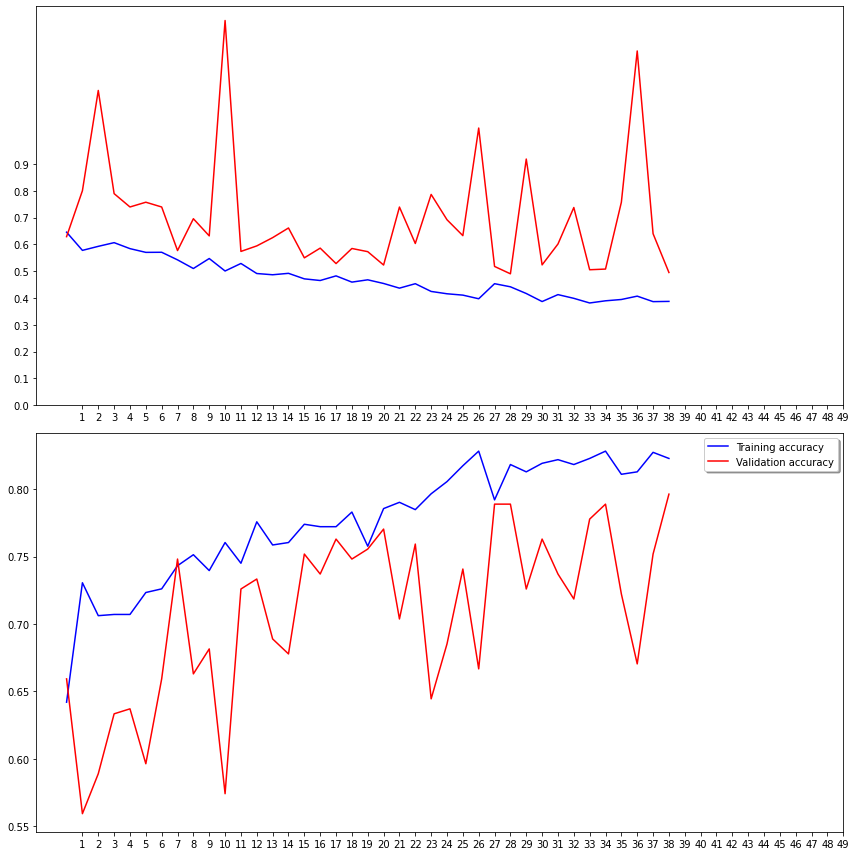

In [64]:
# virtualize training
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Prepare Testing Data

In [65]:
test_filenames = os.listdir("/content/drive/MyDrive/Colab Notebooks/test_500")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Create Testing Generator
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/drive/MyDrive/Colab Notebooks/test_500", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 500 validated image filenames.


In [66]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-66-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [67]:
test_df['category'] = np.argmax(predict, axis=-1)

In [68]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [69]:
test_df['category'] 

0      dog
1      dog
2      cat
3      dog
4      cat
      ... 
495    cat
496    cat
497    cat
498    cat
499    cat
Name: category, Length: 500, dtype: object

In [70]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

In [56]:
test_df['category']

0      0
1      1
2      1
3      1
4      0
      ..
495    0
496    0
497    1
498    0
499    1
Name: category, Length: 500, dtype: int64

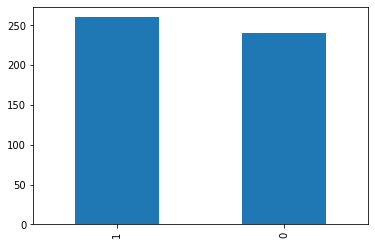

In [57]:
# Virtaulize Result
test_df['category'].value_counts().plot.bar()

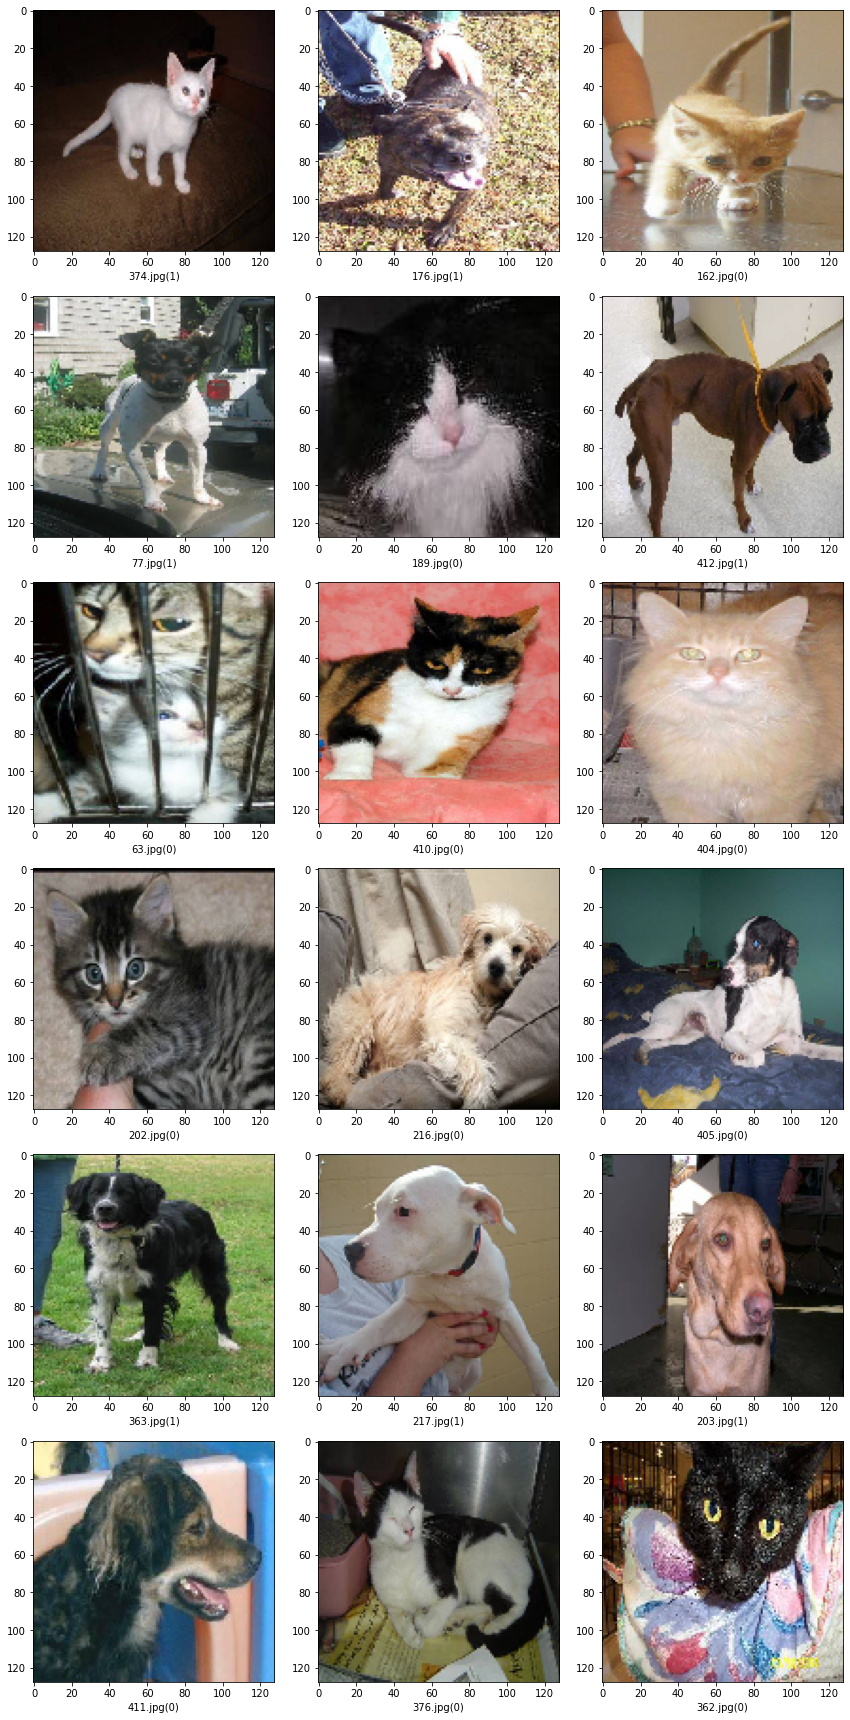

In [71]:
# 시각화
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/drive/MyDrive/Colab Notebooks/test_500/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()